# Sales strategy analysis for "Pens and Printers"

We are tasked with analyzing the effectiveness of three sales strategies used by "Pens and Printers" for their new stationery product line. By evaluating customer reach and revenue generation, our goal is to recommend the optimal sales approach to enhance future product launches.

## 1. Import packages

In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from scipy import stats
from datetime import datetime

# statistical experimentation
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# render figures in notebook
%matplotlib inline

## 2. Load dataset and data preview

In [2]:
# load dataset
data = pd.read_csv('product_sales.csv')

In [3]:
# preview first rows
data.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


## 3. Initial basic EDA

In [4]:
# data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [5]:
# basic statistics (numeric variables)
data.describe()

,week,nb_sold,revenue,years_as_customer,nb_site_visits
count,15000.000000,15000.000000,13926.000000,15000.000000,15000.000000
mean,3.098267,10.084667,93.934943,4.965933,24.990867
std,1.656420,1.812213,47.435312,5.044952,3.500914
min,1.000000,7.000000,32.540000,0.000000,12.000000
25%,2.000000,9.000000,52.470000,1.000000,23.000000
50%,3.000000,10.000000,89.500000,3.000000,25.000000
75%,5.000000,11.000000,107.327500,7.000000,27.000000
max,6.000000,16.000000,238.320000,63.000000,41.000000


From the initial basic EDA we know that:

- the dataset has 15'000 entries
- the dataset has 8 columns: 'week', 'sales_method', 'customer_id', 'nb_sold', 'revenue', 'years_as_customer', 'nb_site_visits' and 'state'
- the dataset contains numeric and categorical variables
- there are no negative values within the numeric variables
- 'revenue' column has 1074 missing values

## 4. Data validation and cleaning steps

We are now ready to perform data wrangling and data validation according to the table information provided.

### 4.1 Dataset overview

#### 4.1.1 Data types

In [6]:
# actual dtypes
actual_dtypes = data.dtypes

# expected dtypes
expected_dtypes = {
    'week': 'int64',
    'sales_method': 'object', # 'character' type corresponds to 'object' dtype in pandas
    'customer_id': 'object',
    'nb_sold': 'int64',
    'revenue': 'float64', # requires 2 decimals which makes 'numeric' a 'float' dtype
    'years_as_customer': 'int64',
    'nb_site_visits': 'int64',
    'state': 'object'
}

# check actual vs expected dtypes
dtype_check = actual_dtypes == pd.Series(expected_dtypes)

In [7]:
# dtype check dataframe
dtype_df = pd.DataFrame({
    'column': actual_dtypes.index,
    'actual_dtype': actual_dtypes.values,
    'check': dtype_check.values
})

print(dtype_df)

              column actual_dtype  check
0               week        int64   True
1       sales_method       object   True
2        customer_id       object   True
3            nb_sold        int64   True
4            revenue      float64   True
5  years_as_customer        int64   True
6     nb_site_visits        int64   True
7              state       object   True


**Data types overview:**

- The data types are as expected when compared to the data validation requirements.

#### 4.1.2 Missing values

In [8]:
# check (already known from step 3.) for missing values
missing_values = data.isnull().sum()
missing_values

week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64

**Missing values overview:**
- The check for missing values confirms that there are no missing values except for the 'revenue' column, which has 1074 missing entries

### 4.2 'week'

In [9]:
# check dtype
week_data_type = data['week'].dtype
week_data_type

dtype('int64')

In [10]:
# check missing values
week_missing_values = data['week'].isnull().sum()
week_missing_values

0

In [11]:
# check if the range of week column values is within 1-6 weeks (new product line launched 6 weeks ago)
week_range_valid = data['week'].between(1, 6).all()
week_range_valid

True

**Validation results for 'week' column:**

- The data type of the column 'week' is 'int64', which is appropriate for week numbers
- There are no missing values in this column
- All values are within the valid range of 1 to 6 (six weeks period since new product line launch)

### 4.3 'sales_method'

In [12]:
# check dtype
sales_method_data_type = data['sales_method'].dtype
sales_method_data_type

dtype('O')

In [13]:
# check missing values
sales_method_missing_values = data['sales_method'].isnull().sum()
sales_method_missing_values

0

In [14]:
# check if column values match the expected categories
expected_methods = ['Email', 'Call', 'Email and call']
sales_method_values_valid = data['sales_method'].isin(expected_methods).all()
sales_method_values_valid

False

Not all values in the column match the expected categories ('Email', 'Call' and 'Email and call'). Let's find all distinct entries that are not expected.

In [15]:
# identify unexpected values not included in expected_methods
unexpected_sales_methods = data[~data['sales_method'].isin(expected_methods)]['sales_method'].unique()
unexpected_sales_methods

array(['Email + Call', 'em + call', 'email'], dtype=object)

There are variations and/or typos of the expected categories. We can clean the data by mapping the unexpected sales methods to the correct expected categories.

In [16]:
# correct entries included in the unexpected sales methods to the expected categories
sales_method_corrections = {
    'Email + Call': 'Email and call',
    'em + call': 'Email and call',
    'email': 'Email'
}

# replace unexpected values with the expected category values
data['sales_method'].replace(sales_method_corrections, inplace=True)

# verify correction by checking unique values again
corrected_sales_methods = data['sales_method'].unique()
corrected_sales_methods

array(['Email', 'Email and call', 'Call'], dtype=object)

**Validation results for 'sales_method' columns:**

- The data type is 'object' (denoted as 'O'), which is suitable for categorical data
- There are no missing values in this column
- All variations have now been standardized to the expected categories: 'Email', 'Email and call' and 'Call'

### 4.4 'customer_id'

In [17]:
# check dtype
customer_id_data_type = data['customer_id'].dtype
customer_id_data_type

dtype('O')

In [18]:
# check missing values
customer_id_missing_values = data['customer_id'].isnull().sum()
customer_id_missing_values

0

In [19]:
# check customer_id uniqueness (15000 unique entries)
unique_customer_ids = data['customer_id'].nunique()

# get total number of entries from shape
total_entries = data.shape[0]

# check if the number of unique_customer_ids equals the total number of entries
customer_id_uniqueness = unique_customer_ids == total_entries

unique_customer_ids, customer_id_uniqueness

(15000, True)

We can also check whether all entries are strings of length 36 and if the UUID format is always the same.

In [20]:
# define regular expression pattern for validating UUID format
uuid_pattern = re.compile(r'^[a-fA-F0-9]{8}-[a-fA-F0-9]{4}-[a-fA-F0-9]{4}-[a-fA-F0-9]{4}-[a-fA-F0-9]{12}$')

# check if all customer_id entries are strings
all_strings = data['customer_id'].apply(lambda x: isinstance(x, str)).all()

# check if all customer_id entries have length of 36
correct_length = data['customer_id'].apply(lambda x: len(x) == 36).all()

# check if all customer_id entries match the UUID pattern
matches_uuid_pattern = data['customer_id'].str.match(uuid_pattern).all()

all_strings, correct_length, matches_uuid_pattern

(True, True, True)

**Validation results for 'customer_id' column:**

- The data type is 'object' ('O') and is appropriate for unique alphanumeric identifiers with hyphens
- There are no missing values in this column
- All 'customer_id' entries are strings with length of 36 and match the UUID pattern
- Each 'customer_id' is unique and the number of unique ids, 15000, matches the total number of entries in the dataset

### 4.4 'nb_sold'

In [21]:
# check dtype
nb_sold_data_type = data['nb_sold'].dtype
nb_sold_data_type

dtype('int64')

In [22]:
# check missing values
nb_sold_missing_values = data['nb_sold'].isnull().sum()
nb_sold_missing_values

0

In [23]:
# check for non-negative values
nb_sold_non_negative = (data['nb_sold'] >= 0).all()
nb_sold_non_negative

True

**Validation results for 'nb_sold' column:**

- The data type is 'int64', which is correct for integer quantities of sold items
- There are no missing values in this column
- All values are non-negative, which is expected for a sales count
- The values in the column range from 7 (min) to 16 (max), which is plausible (3. Initial basic EDA)

### 4.5 'revenue'

In [24]:
# check dtype
revenue_data_type = data['revenue'].dtype
revenue_data_type

dtype('float64')

In [25]:
# check missing values
revenue_missing_values = data['revenue'].isnull().sum()
revenue_missing_values

1074

In [26]:
# drop NaN values to consider actual numeric entries
non_null_revenues = data['revenue'].dropna()

# check for non-negative values within non-missing values
revenue_non_negative = non_null_revenues.ge(0).all()
revenue_non_negative

True

In [27]:
# check if all non-missing values are rounded to 2 decimal places
revenue_round_check = (non_null_revenues == non_null_revenues.round(2)).all()
revenue_round_check

True

In [28]:
# check min/max values
revenue_min = data['revenue'].min()
revenue_max = data['revenue'].max()

revenue_min, revenue_max

(32.54, 238.32)

**Validation results for 'revenue' column:**

- The data type is 'float64', which is suitable for numerical values with decimals
- There are 1074 missing values (NaN) in this column
- There are no negative values within non-missing values, as expected for revenue
- All non-missing entries are rounded to 2 decimal places as expected
- The values in the column range from 32.54 to 238.32, which is plausible (3. Initial basic EDA)

**Handling missing values:**

- We can decide how to handle the missing values depending on the analysis requirements
- Options would include, for example, imputation (i.e. mean/median/mod, regression, KNN), removal or leaving as they are
- Give the lack of clear information about the nature of the missing values and the importance of maintaining data accuracy in financial metrics, we'll leave the missing values as they are. This approach allows for an analysis that respects data integrity and provides a clear picture of the dataset's actual state

### 4.6 'years_as_customer'

In [29]:
# check data type
years_as_customer_data_type = data['years_as_customer'].dtype
years_as_customer_data_type

dtype('int64')

In [30]:
# check missing values
years_as_customer_missing = data['years_as_customer'].isnull().sum()
years_as_customer_missing

0

In [31]:
# check for non-negative values
years_as_customer_non_negative = (data['nb_sold'] >= 0).all()
years_as_customer_non_negative

True

In [32]:
# check number of years since founding year
current_year = datetime.now().year
years_since_1984 = current_year - 1984

years_since_1984

39

In [33]:
# check values range for anomalies
years_as_customer_min = data['years_as_customer'].min()
years_as_customer_max = data['years_as_customer'].max()

years_as_customer_min, years_as_customer_max

(0, 63)

The maximum value for this column (63) is greater than the number of years since foundation (39). We need to identify the rows and decide how to approach this anomaly in the data.

In [34]:
# find rows presenting entries greater than maximum allowed
invalid_years_as_customer = data[data['years_as_customer'] > years_since_1984]
invalid_years_as_customer

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,California


There are two entries within the column that need to be addressed. Based on the balance between data integrity and practicality, we need to make sure that values for the column are capped to 39. To preserve the overall distribution and trends within the data, we assume that the most likely cause is a data entry error. The most practical approach, which also minimizes the data distortion when compared to other methods such as imputation, is to assign 39 to both entries, which is the cap. This method is easy to understand and justify in this analysis report.

In [35]:
# cap values at 39 years
data['years_as_customer'] = data['years_as_customer'].apply(lambda x: min(x, 39))

# check range again after correction
corrected_years_as_customer_min = data['years_as_customer'].min()
corrected_years_as_customer_max = data['years_as_customer'].max()

corrected_years_as_customer_min, corrected_years_as_customer_max

(0, 39)

**Validation results for 'years_as_customer' column:**

- The data type is 'int64', which is correct and suitable for years
- There are no negative and no missing values in this column
- The range, after addressing the anomalies (capping), is from 0 to 39 years, where the value 0 represents a new customer
- No customer relationship is indicated as longer than the company's existence, as expected

### 4.7 'nb_site_visits'

In [36]:
# check data type
nb_site_visits_data_type = data['nb_site_visits'].dtype
nb_site_visits_data_type

dtype('int64')

In [37]:
# check missing values
nb_site_visits_missing_values = data['nb_site_visits'].isnull().sum()
nb_site_visits_missing_values

0

In [38]:
# check values range and anomalies
nb_site_visits_min = data['nb_site_visits'].min()
nb_site_visits_max = data['nb_site_visits'].max()

nb_site_visits_min, nb_site_visits_max

(12, 41)

**Validation results for 'nb_site_visits' column:**

- The data type is 'int64', which is appropriate for representing counts like website visits
- There are no negative and no missing values in this column
- The range is from 12 to 41 visits, which seems truthful and does not suggest any obvious anomalies or outliers

### 4.8 'state'

In [39]:
# check data type
state_data_type = data['state'].dtype
state_data_type

dtype('O')

In [40]:
# check missing values
state_missing_values = data['state'].isnull().sum()
state_missing_values

0

In [41]:
# check number of unique values
state_number_unique_values = data['state'].nunique()
state_number_unique_values

50

In [42]:
# check unique values
state_unique_values = data['state'].unique()
state_unique_values

array(['Arizona', 'Kansas', 'Wisconsin', 'Indiana', 'Illinois',
       'Mississippi', 'Georgia', 'Oklahoma', 'Massachusetts', 'Missouri',
       'Texas', 'New York', 'Maryland', 'California', 'Tennessee',
       'Pennsylvania', 'North Dakota', 'Florida', 'Michigan',
       'North Carolina', 'Hawaii', 'Colorado', 'Louisiana', 'Virginia',
       'New Mexico', 'Arkansas', 'Alaska', 'Oregon', 'New Hampshire',
       'Ohio', 'New Jersey', 'Connecticut', 'Iowa', 'Montana',
       'Washington', 'Kentucky', 'Alabama', 'Nebraska', 'South Carolina',
       'Minnesota', 'South Dakota', 'Delaware', 'Maine', 'Utah',
       'West Virginia', 'Vermont', 'Rhode Island', 'Nevada', 'Idaho',
       'Wyoming'], dtype=object)

We can check if there have been sales in all 50 US states.

In [43]:
# list of US states
us_states = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", 
             "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", 
             "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", 
             "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", 
             "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", 
             "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", 
             "Wisconsin", "Wyoming"]

# standardize state names for comparison list
data_states_upper = data['state'].str.upper().unique()
us_states_upper = [state.upper() for state in us_states]

# check if all state entries in the column are in the list
consistent_format = all(state in us_states_upper for state in data_states_upper)

# check if there are state entries that are not in the list, if yes display them in a list
states_not_in_list = [state for state in data_states_upper if state not in us_states_upper]

consistent_format, states_not_in_list

(True, [])

**Validation for 'state' column:**

- The data type is 'object' ('O'), which is the correct format for textual data like state names
- There are no missing values in this column
- The format of the entries is consistent
- There are 50 unique values, no indications of misspellings or inconsistencies

## 5. Exploratory data analysis

### 5.1 Visualization of unique customers count per sales method

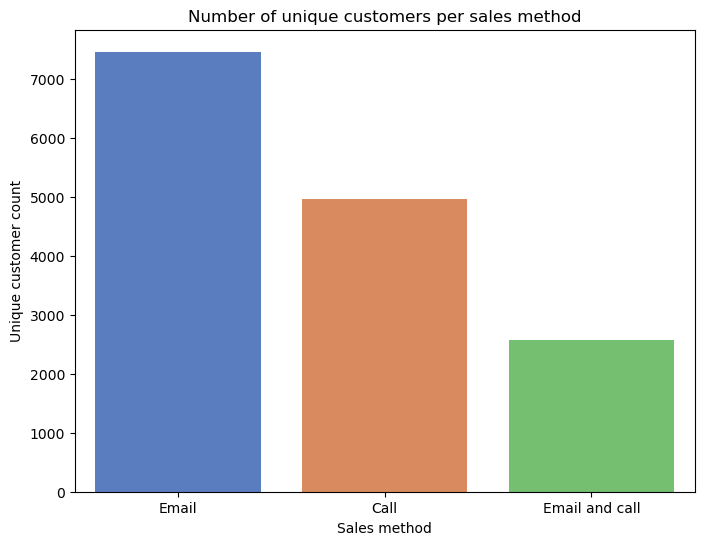

Email sales method: 7466 unique customers
Call sales method: 4962 unique customers
Email and call sales method: 2572 unique customers


In [44]:
# count of 'customer_id' for unique customer identifiers by sales_method
unique_customers_per_method = data.groupby('sales_method')['customer_id'].nunique()

# convert series to df
unique_customers_df = unique_customers_per_method.reset_index()
unique_customers_df.columns = ['Sales method', 'Unique customer count']

# define barplot order
order = ['Email', 'Call', 'Email and call']

# create plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Sales method', y='Unique customer count', data=unique_customers_df, order=order, palette='muted')
plt.title('Number of unique customers per sales method')
plt.xlabel('Sales method')
plt.ylabel('Unique customer count')
plt.show()

# print data
print('Email sales method: ' + str(unique_customers_df['Unique customer count'].iloc[1]) + ' unique customers')
print('Call sales method: ' + str(unique_customers_df['Unique customer count'].iloc[0]) + ' unique customers')
print('Email and call sales method: ' + str(unique_customers_df['Unique customer count'].iloc[2]) + ' unique customers')

#### <span style="color: red;">5.1.1 Q1 answer (based on 5.1)</span>

**Q1: How many customers were there for each approach?**

- 7466 unique customers have been reached by 'Email'
- 4962 unique customers have been reached by 'Call'
- 2572 unique customers have been reached by 'Email and call'

### 5.2 Visualization of revenue

Since there are 1704 missing values for the 'revenue' column, it could be useful to create a visualization that shows the distribution of 'revenue' in different scenarios. Additionally, as we will subsequently start analyzing and comparing the different sale methodologies ('sales_method'), it could be useful to understand the distribution of the missing values per sale methodologies.

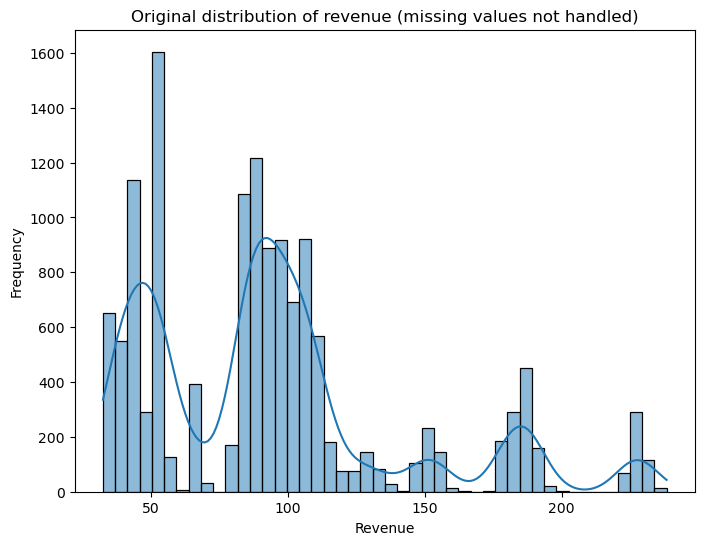

In [45]:
# original distribution disregarding null values
plt.figure(figsize=(8, 6))
sns.histplot(data['revenue'], kde=True)
plt.title('Original distribution of revenue (missing values not handled)')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

#### 5.2.1 Imputation with median

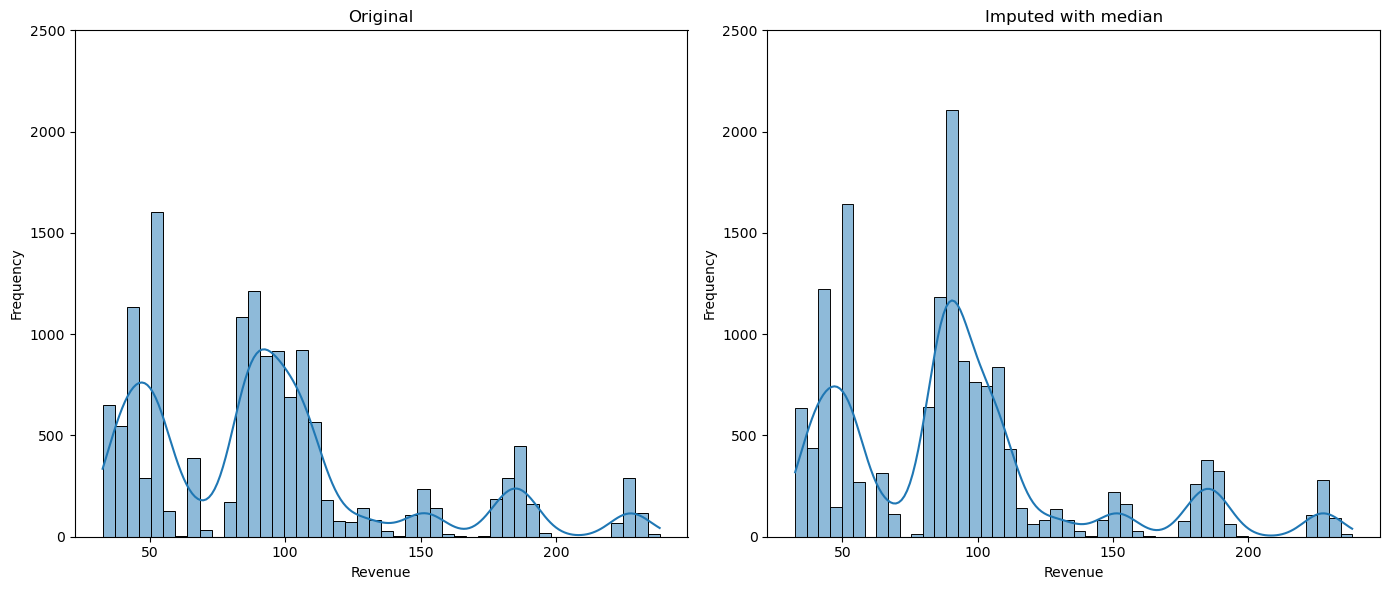

The median revenue is: 89.5


In [46]:
# original distribution vs imputation with median (best alternative for skewed distributions)

# get median revenue
median_revenue = data['revenue'].median()

# create plot with multiple subplots
plt.figure(figsize=(14, 6))

# original distribution disregarding null values
plt.subplot(1, 2, 1)
sns.histplot(data['revenue'].dropna(), kde=True)
plt.title('Original')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.ylim(0, 2500)

# imputation with median (best alternative for skewed distributions)
revenue_imputed_median = data['revenue'].fillna(median_revenue)
plt.subplot(1, 2, 2)
sns.histplot(revenue_imputed_median, kde=True)
plt.title('Imputed with median')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.ylim(0, 2500)

# show plots
plt.tight_layout()
plt.show()

# print median revenue
print('The median revenue is: ' + str(median_revenue))

Both distributions seem to have a similar overall shape, suggesting that imputation hasn't drastically altered the data's distribution. However, the spike at the median value in the imputed plot indicates the added data points.

#### 5.2.2 Revenue NaN count by sales method

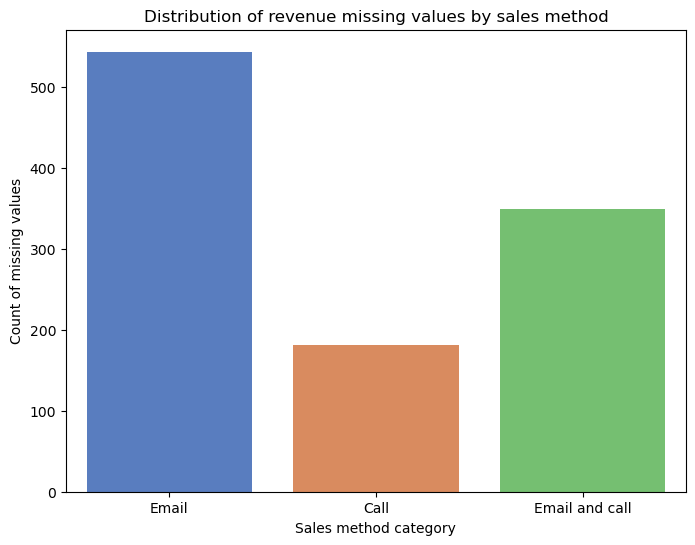

In [47]:
# filter for rows with missing 'revenue'
missing_revenue_data = data[data['revenue'].isnull()]

# count 'sales_method' occurences in the missing revenue data
missing_revenue_method = missing_revenue_data['sales_method'].value_counts()

# create visualization
plt.figure(figsize=(8, 6))
sns.barplot(x=missing_revenue_method.index, y=missing_revenue_method.values, order=order, palette='muted')
plt.title('Distribution of revenue missing values by sales method')
plt.xlabel('Sales method category')
plt.ylabel('Count of missing values')
plt.show()

In [48]:
# check for total missing values (should be 1074)
missing_revenue_method.sum()

1074

#### 5.2.3 Revenue count by sales method (stacked)

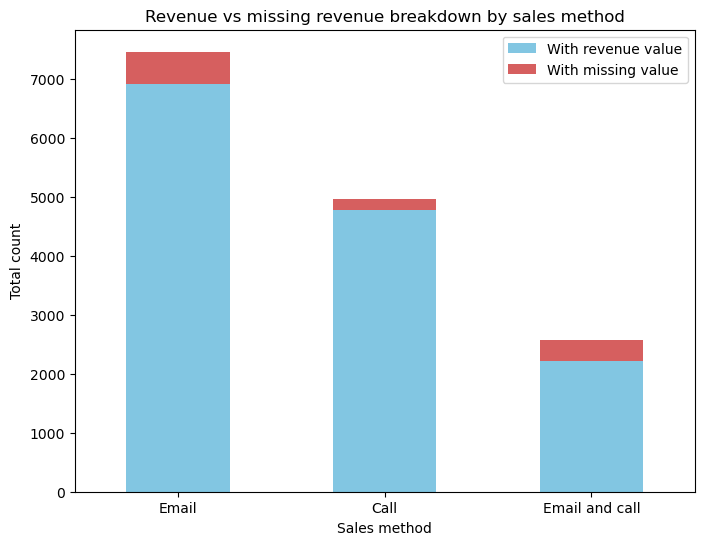

In [49]:
# count total occurences by sales method and count of missing values for each sales method
total_sales_method = data['sales_method'].value_counts()
missing_sales_method = data[data['revenue'].isnull()]['sales_method'].value_counts()

# create dataframe for visualization (entries with and without revenue value)
sales_method_df = pd.DataFrame({'With revenue value': total_sales_method - missing_sales_method, 'With missing value': missing_sales_method})
sales_method_df = sales_method_df.fillna(0)
sales_method_df = sales_method_df.reindex(order)

# create stacked bar chart
muted_colors = ['#82C6E2', '#D65F5F']
sales_method_df.plot(kind='bar', stacked=True, figsize=(8, 6), color=muted_colors)
plt.title('Revenue vs missing revenue breakdown by sales method')
plt.xlabel('Sales method')
plt.ylabel('Total count')
plt.xticks(rotation=0)
plt.show()

In [50]:
# values check
sales_method_df

,With revenue value,With missing value
Email,6922,544
Call,4781,181
Email and call,2223,349


#### 5.2.4 Revenue % of missing values by sales method

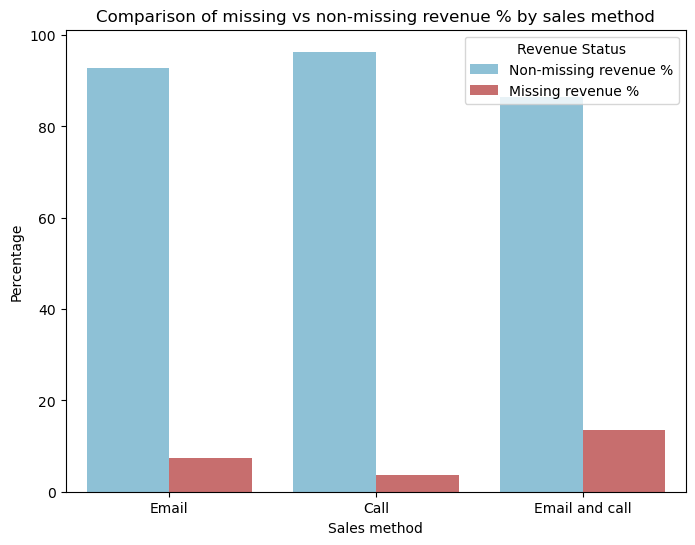

In [51]:
# calculate total occurrences for non-missing values by subtracting missing from total occurrences
non_missing_sales_method = total_sales_method - missing_sales_method

# calculate % for missing and non-missing values
sales_method_df['Non-missing revenue %'] = (non_missing_sales_method / total_sales_method) * 100
sales_method_df['Missing revenue %'] = (missing_sales_method / total_sales_method) * 100

# prepare data for plot
percentage_df = sales_method_df[['Non-missing revenue %', 'Missing revenue %']]
percentage_df = percentage_df.reset_index()
percentage_df_melted = percentage_df.melt(id_vars='index', var_name='Revenue Status', value_name='Percentage')

# create plot
plt.figure(figsize=(8, 6))
sns.barplot(x='index', y='Percentage', hue='Revenue Status', data=percentage_df_melted, palette=muted_colors)
plt.title('Comparison of missing vs non-missing revenue % by sales method')
plt.xlabel('Sales method')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [52]:
missing_sales_method

Email             544
Email and call    349
Call              181
Name: sales_method, dtype: int64

In [53]:
# 'revenue' dataframe overview
sales_method_df

,With revenue value,With missing value,Non-missing revenue %,Missing revenue %
Email,6922,544,92.713635,7.286365
Call,4781,181,96.352277,3.647723
Email and call,2223,349,86.430793,13.569207


**Considerations for 'revenue' missing data:**

- The % of missing values varies significantly among sales method, with 'Email and call' notably higher
- The missing data could skew the results, especially if the reason is not random
- A further investigation for the cause of those missing values might be needed
- Further analysis into the pattern of the missing values (check if missingness correlates vith other variables)

#### 5.2.5 Sensitivity and correlation analysis

In [54]:
# sensitivity analysis before vs after imputation
summary_original = data['revenue'].describe()
summary_imputed = revenue_imputed_median.describe()

# correlation before vs after imputation
correlation_original = data.corr()['revenue']
correlation_imputed = data.assign(revenue_imputed=revenue_imputed_median).corr()['revenue_imputed']

# display summary statistics and correlation comparisons
summary_comparison = pd.DataFrame({'Original': summary_original, 'Imputed': summary_imputed})
correlation_comparison = pd.DataFrame({'Original': correlation_original, 'Imputed': correlation_imputed})

# drop self correlation
summary_comparison, correlation_comparison.drop('revenue_imputed')

(           Original       Imputed
 count  13926.000000  15000.000000
 mean      93.934943     93.617401
 std       47.435312     45.719775
 min       32.540000     32.540000
 25%       52.470000     53.040000
 50%       89.500000     89.500000
 75%      107.327500    106.070000
 max      238.320000    238.320000,
                    Original   Imputed
 nb_site_visits     0.323089  0.309244
 nb_sold            0.696165  0.660017
 revenue            1.000000  1.000000
 week               0.356179  0.340800
 years_as_customer -0.064873 -0.062276)

**Worth mentioning about sensitivity and correlation:**

- Both distributions seem to have a similar overall shape, but the imputed has a spike at median value
- The mean and std are slightly lower in the imputed dataset
- The 25% and 75% quartiles show minor differences
- The correlation values are slightly lower in the imputed dataset for all variables

### 5.3 Spread of revenue

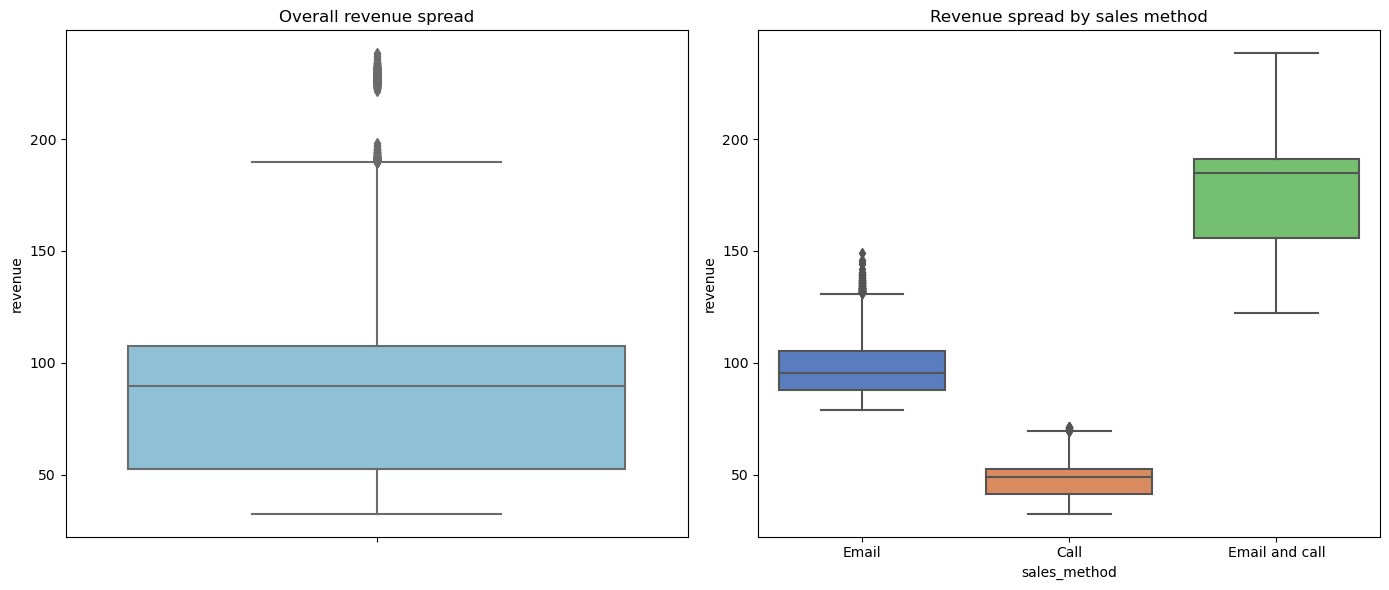

In [55]:
# overall revenue spread
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=data['revenue'], color='#82C6E2')
plt.title('Overall revenue spread')

# revenue spread by sales_method
plt.subplot(1, 2, 2)
sns.boxplot(x='sales_method', y='revenue', order=order, data=data, palette='muted')
plt.title('Revenue spread by sales method')

#plot
plt.tight_layout()
plt.show()

In [56]:
# descriptive stats for overall revenue (same as initial basic EDA)
overall_stats = data['revenue'].describe()

# convert series to dataframe
overall_stats_df = overall_stats.to_frame()
overall_stats_df.columns = ['overall']

# calculate IQR spread for overall revenue
iqr = overall_stats['75%'] - overall_stats['25%']

# add IQR spread to dataframe
overall_stats_df.loc['IQR'] = iqr

overall_stats_df = overall_stats_df.T

# show df
overall_stats_df

,count,mean,std,min,25%,50%,75%,max,IQR
overall,13926.0,93.934943,47.435312,32.54,52.47,89.5,107.3275,238.32,54.8575


In [57]:
# descriptive statistics for the revenue by each sales method
method_stats = data.groupby('sales_method')['revenue'].describe()

# index reset to turn multi-index series into a dataframe
method_stats_df = method_stats.reset_index()

# add IQR spread to dataframe
method_stats_df['IQR'] = method_stats_df['75%'] - method_stats_df['25%']

# show df
method_stats_df

,sales_method,count,mean,std,min,25%,50%,75%,max,IQR
0,Call,4781.0,47.597467,8.609899,32.54,41.470,49.07,52.68,71.36,11.210
1,Email,6922.0,97.127684,11.210469,78.83,87.880,95.58,105.17,148.97,17.290
2,Email and call,2223.0,183.651233,29.083924,122.11,155.775,184.74,191.11,238.32,35.335


#### <span style="color: red;">5.3.1 Q2 answer (based on 5.3)</span>

**Q2: What does the spread of the revenue look like overall? And for each method?**

**Considerations for 'revenue' spread:**

- Overall 'revenue' has a considerable spread (IQR method) of 54.85
- The value range is from 32.54 to 238.32, indicating diverse revenue amounts across all revenues
- Median is 89.50, which suggests that half of the sales transactions generate less than this amount
- IQR, from 52.47 to 107.33, captures the middle 50% of the revenue data
- There is a significant numbe of outliers, particularly on the higher end, which indicates that there are several instances where revenue is exceptionally high

**Considerations for revenue spread by sales method:**

- 'Email': broather IQR than 'Call' but narrower than 'Email and call' (moderate variability in revenue)
- 'Email': median value is higher than the 'Call' method (95.58 vs 49.07), meaning email method generates typically more revenue per sale
- 'Email': outliers are present indicating occasional higher revenue sales
- 'Call': smallest IQR among the sales methods, indicating more consistent sales outcomes
- 'Call': median revenue is the lowest with 49.07 (less revenue per sale)
- 'Call': fewer outliers compared to other sales methods and rarely results in very high revenues
- 'Email and call': widest IQR, showing the greatest variability in revenue among the three methods
- 'Email and call': highest median revenue (184.74), which indicates its potential to generate high revenue per sale
- 'Email and call': the spread presents high-revenue values, suggesting that the combined method is effective

### 5.4 Correlation analysis

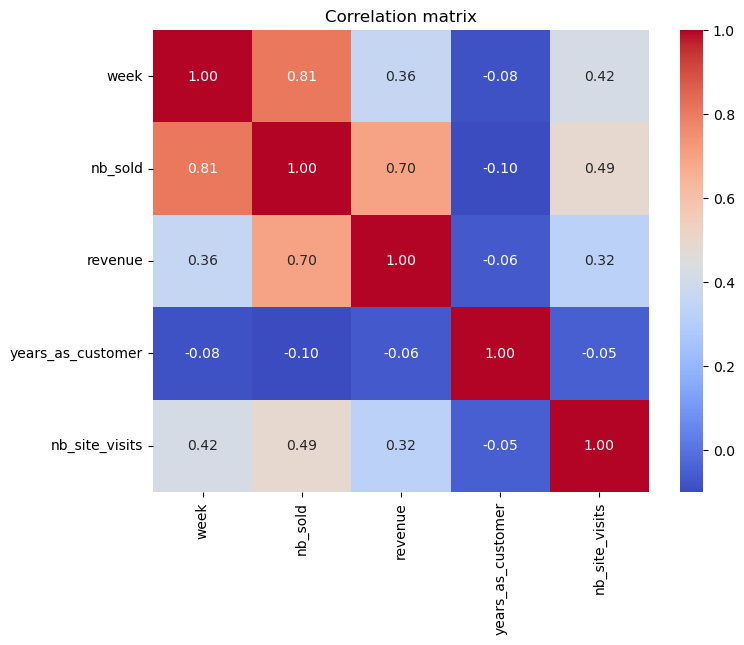

In [58]:
# create correlation matrix
correlation_matrix = data.corr()

# plot correlation matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.show()

**Considerations for correlation heatmap:**

- Correlation between 'nb_sold' and 'revenue' is positive and strong, as expected (more sales higher revenue)
- Correlation between 'nb_sold' and 'week' is positive and strong (might be due do an initial ramp-up phase where sales are increasing week by week)
- Correlation between 'nb_site_visits' and both 'revenue' and 'nb_sold' is positive and moderate (more site visits might be associated with higher sales and revenue, indicating potential customer engagement)
- Correlation between 'years_as_customer' and 'revenue' is weak and negative (new customers might be generating more revenue initially)

### 5.5 Sales methods impact over time

#### 5.5.1 Revenue over time vs n. units sold and vs. n. site visits

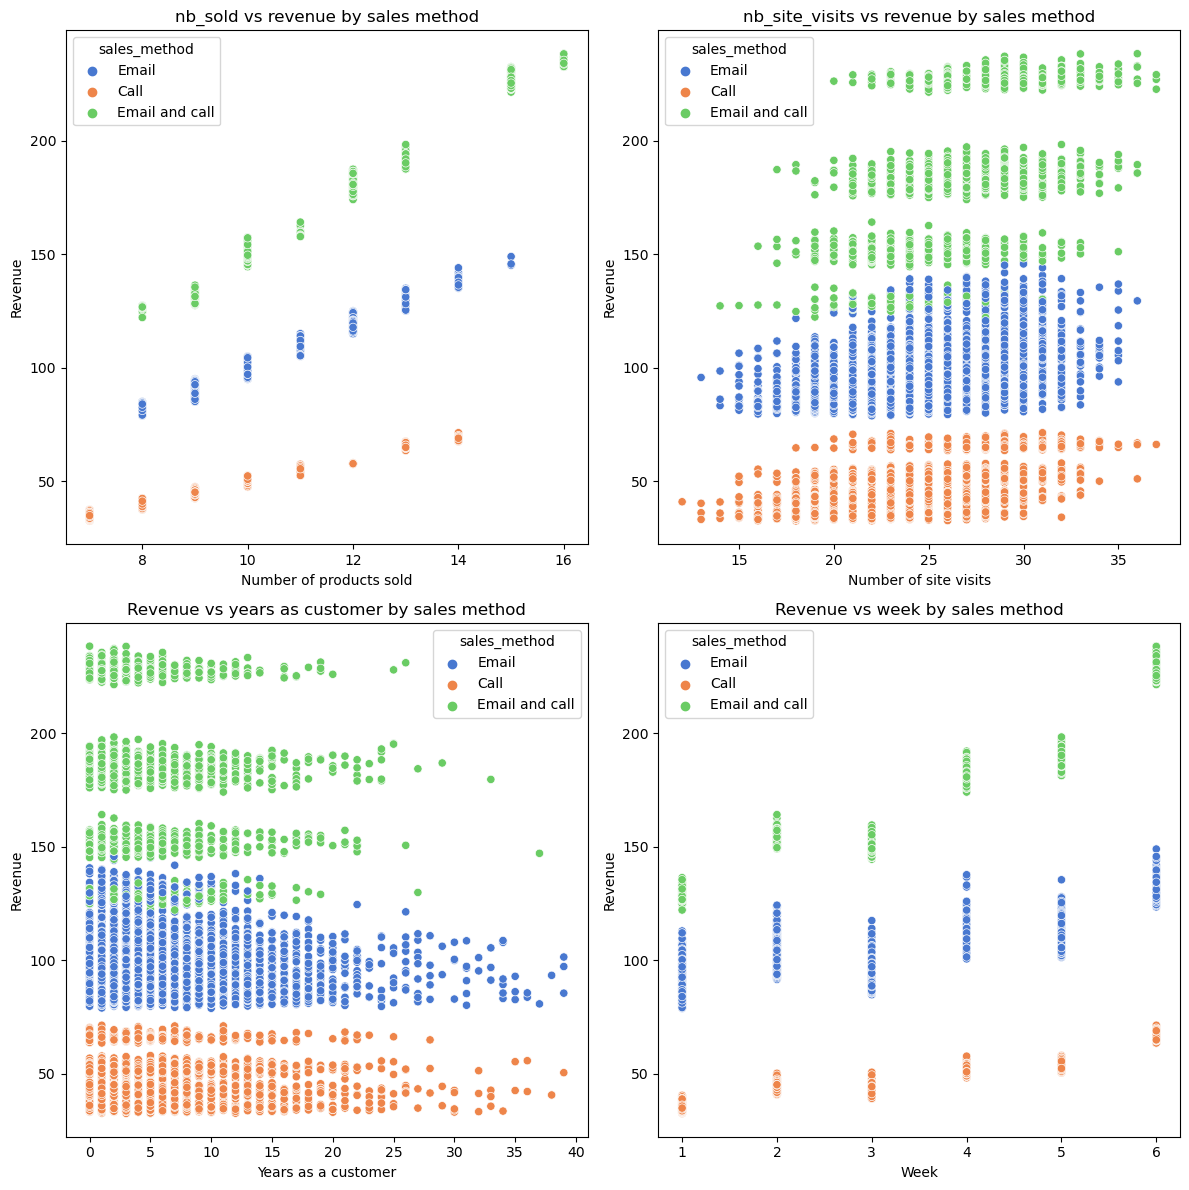

In [59]:
# create scatter plot 'nb_sold' vs 'revenue' and 'nb_site_visits' vs 'revenue', colored by sales_method

# create figure
plt.figure(figsize=(12, 12))

# 'nb_sold' vs 'revenue', colored by sales_method
plt.subplot(2, 2, 1)
sns.scatterplot(x='nb_sold', y='revenue', hue='sales_method', hue_order=order, data=data, palette='muted')
plt.title('nb_sold vs revenue by sales method')
plt.xlabel('Number of products sold')
plt.ylabel('Revenue')

# 'nb_site_visits' vs 'revenue', colored by sales_method
plt.subplot(2, 2, 2)
sns.scatterplot(x='nb_site_visits', y='revenue', hue='sales_method', hue_order=order, data=data, palette='muted')
plt.title('nb_site_visits vs revenue by sales method')
plt.xlabel('Number of site visits')
plt.ylabel('Revenue')

# 'revenue' vs 'years_as_customer', colored by sales_method
plt.subplot(2, 2, 3)
sns.scatterplot(x='years_as_customer', y='revenue', hue='sales_method', hue_order=order, data=data, palette='muted')
plt.title('Revenue vs years as customer by sales method')
plt.xlabel('Years as a customer')
plt.ylabel('Revenue')

# 'revenue' vs 'week', colored by sales_method
plt.subplot(2, 2, 4)
sns.scatterplot(x='week', y='revenue', hue='sales_method', hue_order=order, data=data, palette='muted')
plt.title('Revenue vs week by sales method')
plt.xlabel('Week')
plt.ylabel('Revenue')

# plot
plt.tight_layout()
plt.show()

#### 5.5.2 Grouped analysis by sales_method

In [60]:
# grouped analysis by sales_method
grouped_data = data.groupby('sales_method').agg({'revenue': ['mean', 'median', 'sum'],
                                                 'nb_sold': ['mean', 'median', 'sum'],
                                                 'nb_site_visits': ['mean', 'median']})

# get columns, reset index and print
grouped_data.columns = ['_'.join(col).strip() for col in grouped_data.columns.values]
grouped_data.reset_index(inplace=True)
grouped_data

,sales_method,revenue_mean,revenue_median,revenue_sum,nb_sold_mean,nb_sold_median,nb_sold_sum,nb_site_visits_mean,nb_site_visits_median
0,Call,47.597467,49.07,227563.49,9.509674,10.0,47187,24.423821,24.0
1,Email,97.127684,95.58,672317.83,9.729306,10.0,72639,24.754353,25.0
2,Email and call,183.651233,184.74,408256.69,12.225505,12.0,31444,26.771384,27.0


#### <span style="color: red;">5.5.3 Q3 answer part 1 (based on 5.5)</span>

**Q3: Was there any difference in revenue over time for each of the methods? (part 1)**

**Considerations for revenue over time vs n. units sold and vs. n. site visits:**

- 'nb_sold' vs 'revenue': positive relationship evident across all sales methods, with 'Email and call' category having the highest revenues at all nb_sold levels (more effective)
- 'nb_site_visits' vs 'revenue': relationship less pronounced, with 'Email and call' highest revenue category
- 'revenue' vs 'years_as_customer': relationship is not straightforward but the plot further confirms better revenue generation for 'Email and call' sales_method, then 'Email' and 'Call'
- 'revenue' vs' week': increasing revenue week over week for all categories, the segmentation by sales method strengthens once again the fact that 'Email and call' performs best compared to 'Email' and 'Call'

**Considerations for grouped analysis by sales_method:**

- 'Email and call' outperforms both 'Email' and 'Call' sales methods in terms of average and median revenue
- 'revenue_sum' shows that despite the higher average of 'Email and call', the 'Email' method led to the highest total revenue (due to the larger number of transaction made through the 'Email' method
- 'nb_sold' mean and median demonstrate the higher effectiveness (more product per transaction and more revenue per sale)
- 'nb_sold_sum', similar to 'revenue_sum', shows 'Email' as the highest products sold method (due once again to the larger number of transactions)
- 'nb_site_visits' mean and median are higher once again for 'Email and call' sales method category (could suggest better engagement or more effective marketing strategies with the combined approach)

### 5.6 Time series analysis

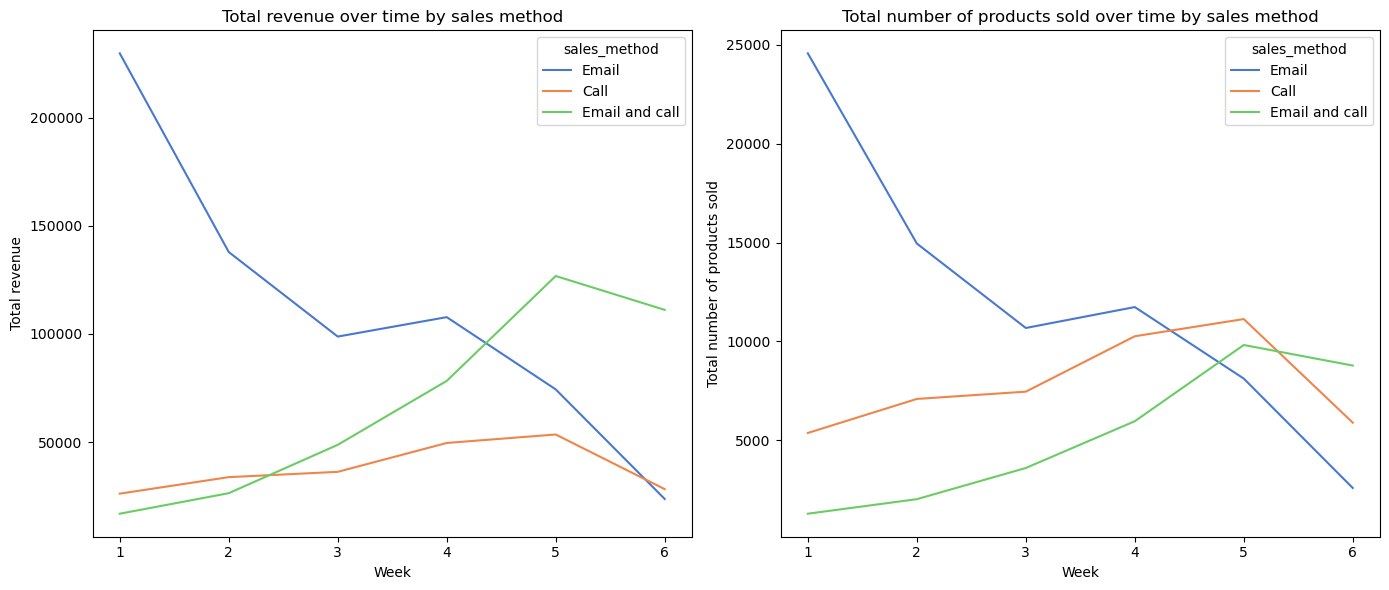

In [61]:
# aggregate metrics by week and sales_method
weekly_aggregate_by_method_filtered = data.groupby(['week', 'sales_method']).agg({
    'revenue': 'sum',
    'nb_sold': 'sum'
}).reset_index()

# visualize trends over time by sales_method
plt.figure(figsize=(14, 6))

# revenue over time by sales_method
plt.subplot(1, 2, 1)
sns.lineplot(x='week', y='revenue', hue='sales_method', hue_order=order, data=weekly_aggregate_by_method_filtered, palette='muted')
plt.title('Total revenue over time by sales method')
plt.xlabel('Week')
plt.ylabel('Total revenue')

# number of products sold over time by sales_method
plt.subplot(1, 2, 2)
sns.lineplot(x='week', y='nb_sold', hue='sales_method', hue_order=order, data=weekly_aggregate_by_method_filtered, palette='muted')
plt.title('Total number of products sold over time by sales method')
plt.xlabel('Week')
plt.ylabel('Total number of products sold')

# plot
plt.tight_layout()
plt.show()

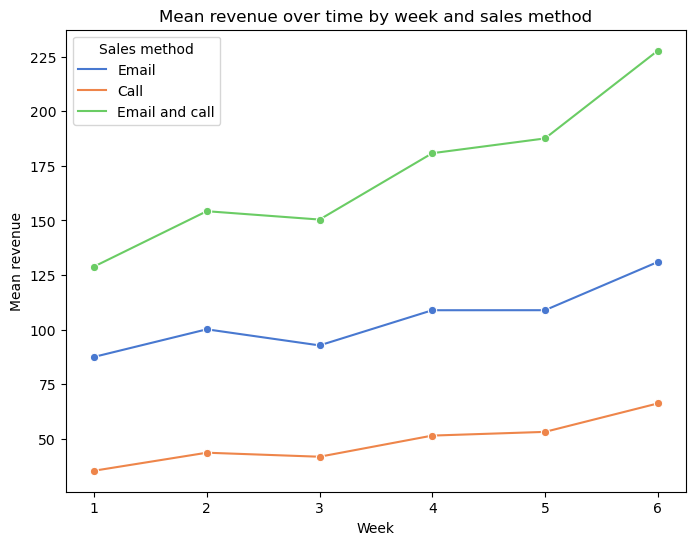

In [62]:
# revenue mean by week and sales_method
mean_weekly_revenue_by_method = data.groupby(['week', 'sales_method'])['revenue'].mean().reset_index()

# plot the revenue mean over time by week and by sales method
plt.figure(figsize=(8, 6))
sns.lineplot(x='week', y='revenue', hue='sales_method', hue_order=order, data=mean_weekly_revenue_by_method, marker='o', palette='muted')
plt.title('Mean revenue over time by week and sales method')
plt.xlabel('Week')
plt.ylabel('Mean revenue')
plt.legend(title='Sales method')
plt.show()

In [63]:
# pivot mean weekly revenue by method
pivot_mean_weekly_revenue = mean_weekly_revenue_by_method.pivot(index='week', columns='sales_method', values='revenue')

# reset index and show df
pivot_mean_weekly_revenue.reset_index(inplace=True)
pivot_mean_weekly_revenue

sales_method,week,Call,Email,Email and call
0,1,35.350243,87.496401,128.895649
1,2,43.602606,100.139121,154.246959
2,3,41.759528,92.762573,150.423272
3,4,51.446048,108.877141,180.822633
4,5,53.146087,108.892313,187.588343
5,6,66.166089,130.976519,227.770635


#### <span style="color: red;">5.6.1 Q3 answer part 2 (based on 5.6)</span>

**Q3: Was there any difference in revenue over time for each of the methods? (part 2)**

**Considerations for revenue over time by sales method:**

- The revenue trends for each sales method vary notabily over the weeks
- 'Email' method performance has been drastically decreasing week over week (WOW)
- 'Call' method generally shows lower revenue than other methods
- 'Email and call' method shows an significant increase WOW, suggesting it might be more effective in generating higher revenue per sale in the future

**Considerations for number of products sold over time by sales method:**

- The number of products sold trends for each sales method vary notabily over the weeks
- 'Email' method is performing worse and worse WOW
- 'Call' method still contributes a significat volume of sales
- 'Email and call' method shows an increase in effectiveness WOW an significant increase WOW

**Overall consideration for time series analysis (total revenue):**

- Based on these insights, a strategic focus on 'Email and call' method for future sales initiatives could be advisable, particularly when aiming to maximize revenue and sales volume
- The 'Email and call' method appears to capitalize on the strenghts of both individual sales methods, prividing both reach and personalized engagement, which seems to resonate effectively with customers

**Overall consideration for time series analysis (mean revenue):**

- There is a consistent increase in mean revenue over the weeks for 'Email and call'
- 'Call' shows an increasing trend and 'Email' remains relatively flat with a slight increase
- 'Email and call' outperforms the other two methods in terms of mean revenue per week
- Once again the effectiveness of the combined 'Email and call' approach suggests that the personal touch of a call coupled with the efficiency of an email could be contributing to higher customer spend

**Additional thoughts:**

- Effort required for each method differs: 'Email' has the least effort, involtving sending two emails in two weeks. 'Call' has a high effort, with approximately 30 minutes per call. The combined 'Email and call' method has moderate effort, combining an email and a shorter call of around 10 minutes
- The decision should balance the effort required and the results achieved. While the 'Email and call' method is more time-consuming than just sending emails, the increased revenue and engagement seems to justify this extra effort, especially for high-value customers of key market segments
- The different efforts once again strengthen the suggestion to focus on the 'Email and call' method as it generally produces higher revenue and sales volume compared to other methods
- The mixed sales method 'Email and call' offerts the best balance between personalized engagement and reach, capitalizing and synergizing on the strenghts of both individual sales methods.

### 5.7 Group by state and sales method insights

In [64]:
# group data by state and sales_method
sales_method_effectiveness = data.groupby(['state', 'sales_method']).agg({
    'revenue': ['mean', 'sum'],
    'nb_sold': ['mean', 'sum']
}).reset_index()

# flatten multi level column names
sales_method_effectiveness.columns = ['_'.join(col).rstrip('_') if col[1] else col[0] for col in sales_method_effectiveness.columns.values]

# covert 'sales_method' to categorcal to order categories as previous analysis
sales_method_effectiveness['sales_method'] = pd.Categorical(
    sales_method_effectiveness['sales_method'], 
    categories=["Email", "Call", "Email and call"], 
    ordered=True
)

# sort the data for visualization and analysis
sales_method_effectiveness_sorted = sales_method_effectiveness.sort_values(by=['state', 'sales_method'], ascending=True)

# display top rows to check
sales_method_effectiveness_sorted.head()

,state,sales_method,revenue_mean,revenue_sum,nb_sold_mean,nb_sold_sum
1,Alabama,Email,96.841028,10361.99,9.678571,1084
0,Alabama,Call,46.421311,2831.70,9.380952,591
2,Alabama,Email and call,187.946176,6390.17,12.461538,486
4,Alaska,Email,101.971111,1835.48,10.047619,211
3,Alaska,Call,48.784615,634.20,9.846154,128


In [65]:
# create pivot table
pivot_table = sales_method_effectiveness.pivot_table(
    index='state', 
    columns='sales_method', 
    values='revenue_mean'
)

# create boolean column
pivot_table['condition_met'] = (
    (pivot_table['Email and call'] > pivot_table['Email']) & 
    (pivot_table['Email'] > pivot_table['Call'])
)

# rename columns
pivot_table = pivot_table.rename(columns={'Email': 'email', 'Call': 'call', 'Email and call': 'email_and_call'})

# reset index
pivot_table.reset_index(inplace=True)

# display results
pivot_table

sales_method,state,email,call,email_and_call,condition_met
0,Alabama,96.841028,46.421311,187.946176,True
1,Alaska,101.971111,48.784615,182.577500,True
2,Arizona,96.878881,48.381875,179.604898,True
3,Arkansas,94.138367,46.676939,194.771500,True
4,California,97.267029,47.896312,183.018897,True
5,Colorado,96.871351,48.723099,177.780667,True
6,Connecticut,97.677639,46.211379,179.448649,True
7,Delaware,98.732857,42.682857,183.296667,True
8,Florida,97.372500,48.780105,182.625038,True
9,Georgia,97.590164,46.804392,186.578824,True


**Overall consideration 'state' vs 'sales_method' grouped analysis:**

- The pivot table above with check, with a boolean value, if the category 'Email and call' performs better in terms of revenue when compared to 'Email', and then 'Call'
- The mean revenue in each state is always higher for 'Email and call', no difference across states

## <span style="color: red;">6. Q4 answer recommendation</span>

**Q4: Based on the data, which method would you recommend we continue to use? Some
of these methods take more time from the team so they may not be the best for us to use if the results are similar.**

Based on the comprehensive analysis of the sales data, I recommend the company prioritize the 'Email and call' method for future sales initiatives. This method has consistently demonstrated the highest median revenue, indicating its effectiveness in generating significant sales per customer. Furthermore, there's a clear positive trend over time in revenue performance, suggesting that its impact is growing. It is also associated with increased customer engagement, as evidenced by higher site visits, which are crucial for building long-term customer relationships and loyalty. While it requires more effort than the 'Email' method, the 'Email and call' approach yields a substantial number of high-revenue transactions, making it a strategically valuable option for capturing high-value customers across diverse markets. The method's alignment with the company's strategic sales goals (to maximize revenue and effectively engage customers) along with its demonstrated success across multiple metrics, strongly supports its continued use despite the higher time investment it demands.

Below a breakdown of the 10 key characteristics of the 'Email and call' method.

**Superior revenue generation:**

- The 'Email and call' method stands out for its highest median revenue generation, indicating that it's more likely to result in higher sales per customer than the other method

**Consistent performance improvement:**

- Data shows a positive trend in revenue week over week for the 'Email and call' method, suggesting that its efficacy is improving over time, which could predict continued success

**High customer engagement:**

- The 'Email and call' method correlates with more customer site visits, a proxy for engagement, which is often a precursor to higher conversion rates and customer loyalty

**Capturing high-value transaction:**

- This method not only achieves a greater number of high-revenue outliers but also the highest average revenue per transaction, making it strategically valuable for capturing high-value customers

**Effective market penetration:**

- Across different states, the 'Email and call' method consistently yields higher mean revenue, demonstrating its effectiveness regardless of regional market differences

**Volume of sales:**

- Despite the 'Email' method resulting in the highest total number of transactions, the 'Email and call' method's superior revenue per transaction suggests that it's more efficient, especially for a smaller, focused sales force

**Cost-benefit justification:**

- The additional time investment for 'Email and call' is offset by its higher revenue outcomes, suggesting that the method is likely to have a better cost-benefit ratio compared to 'Email' or 'Call' alone

**Customer purchase power:**

- The 'Email and call' method leads to higher average product purchases, indicating that this approach may be more effective at influencing customer purchase decisions

**Long-term customer value:**

- The method appears to resonate with both new and long-standing customers, indicating its potential to enhance long-term customer value through sustained engagement

**Strategic alignment with sales goals:**

- If the sales team's goal is to maximize revenue rather than simply increasing the number of transactions, the 'Email and call' method aligns better with this objective due to its higher revenue generation capability

## 7. Further customer segmentation

### 7.1 By purchase volume and site engagement level

In [66]:
# segmentation by purchase volume

# calculate total products sold per customer
total_products_per_customer = data.groupby('customer_id')['nb_sold'].sum().reset_index()

# get median number of products sold for segmentation
median_products_sold = total_products_per_customer['nb_sold'].median()

# segmento customers into 'Standard' and 'Volume' segments
total_products_per_customer['purchase_volume'] = ['High Volume' if x > median_products_sold else 'Standard' for x in total_products_per_customer['nb_sold']]

# segmentation by site engagement level

# calculate average site visits (#and years as customer)
average_site_visits = data['nb_site_visits'].mean()
#average_years_as_customer = data['years_as_customer'].mean()

# set engagement levels based on site visits (#and years as customer above mean)
data['site_engagement_level'] = data.apply(lambda row: 'High' if row['nb_site_visits'] > average_site_visits else 'Low', axis=1)
#data['site_engagement_level'] = data.apply(lambda row: 'High' if row['nb_site_visits'] > average_site_visits and row['years_as_customer'] > average_years_as_customer else 'Low', axis=1)

# insert segmentation results into dataframe
customer_segments = total_products_per_customer.merge(data[['customer_id', 'nb_site_visits', 'site_engagement_level']].drop_duplicates(), on='customer_id')

# quick display dataframe with segments
customer_segments.head()

,customer_id,nb_sold,purchase_volume,nb_site_visits,site_engagement_level
0,00019f95-cd18-4a2a-aa62-512cc6b17ac5,12,High Volume,28,High
1,00020b38-1ebb-427f-88d1-c60f3c426cfe,12,High Volume,31,High
2,0002aed1-1a1f-4b20-845f-7a4b8cc9977a,16,High Volume,29,High
3,00058065-ed47-4bc0-b74e-6803d0b67644,8,Standard,26,High
4,0011e7a6-9bda-4624-a115-f39866330cc8,12,High Volume,25,High


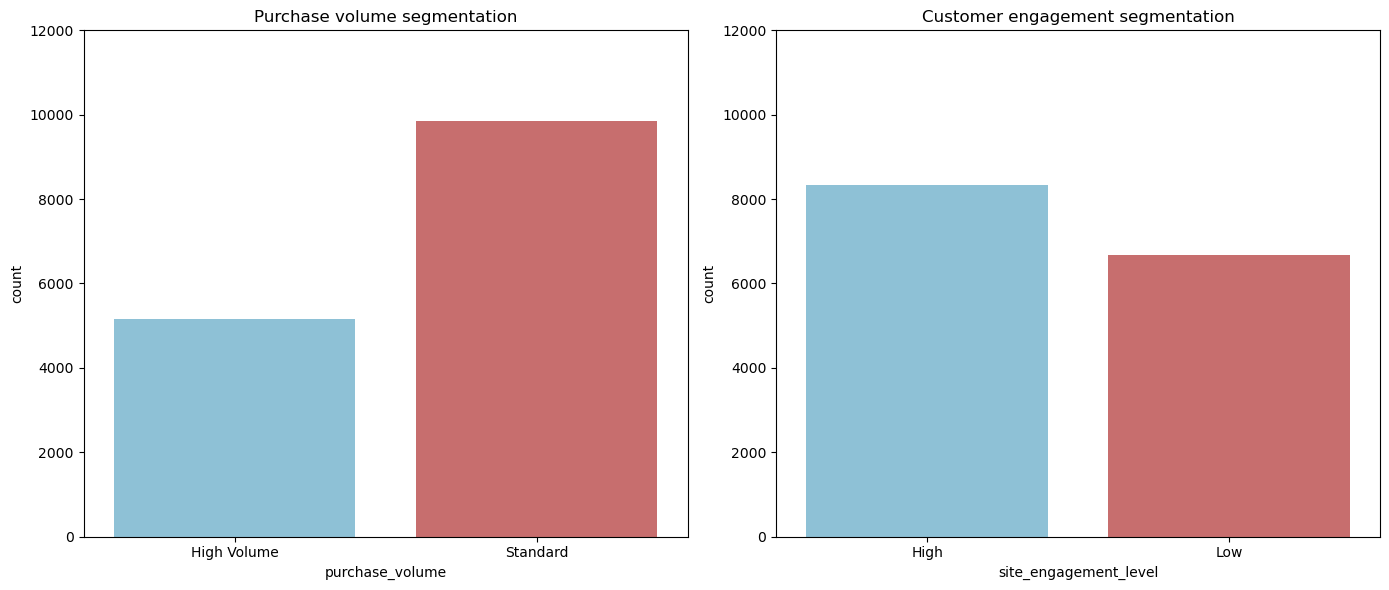

In [67]:
# create visualization
plt.figure(figsize=(14, 6))

# visualize product sold segmentation
plt.subplot(1, 2, 1)
sns.countplot(x='purchase_volume', data=customer_segments, palette=muted_colors)
plt.title('Purchase volume segmentation')
plt.ylim(0, 12000)

# visualize customer segment segmentation
plt.subplot(1, 2, 2)
sns.countplot(x='site_engagement_level', data=customer_segments, palette=muted_colors)
plt.title('Customer engagement segmentation')
plt.ylim(0, 12000)

# show plots
plt.tight_layout()
plt.show()

In [68]:
# get % breakdown for segmentations
purchase_volume_percentages = customer_segments['purchase_volume'].value_counts(normalize=True) * 100
engagement_level_percentages = customer_segments['site_engagement_level'].value_counts(normalize=True) * 100

In [69]:
# % purchase volume segmentation
purchase_volume_percentages

Standard       65.673333
High Volume    34.326667
Name: purchase_volume, dtype: float64

In [70]:
# median products sold
median_products_sold

10.0

In [71]:
# % customer engagement segmentation
engagement_level_percentages

High    55.56
Low     44.44
Name: site_engagement_level, dtype: float64

In [72]:
# average (mean) site visits
average_site_visits

24.990866666666665

**Considerations for purchase volume segmentation:**

- Distribution of customers into 'High Volume' and 'Standard' buyers, based on the total number of products purchased by each customer in comparison to the median
- 34.33% of customers buy at least 10 items (median), 65.67% buy less

**Considerations for site engagement level segmentation:**

- Distribution of customers into 'High' and 'Low' customers, based on the number of site visits in comparison to the average
- 55.56% of customers have visited the website more than the average, which is 24.99 times, 44.44% visited less

### 7.2 By geographical location (customers count and units sold)

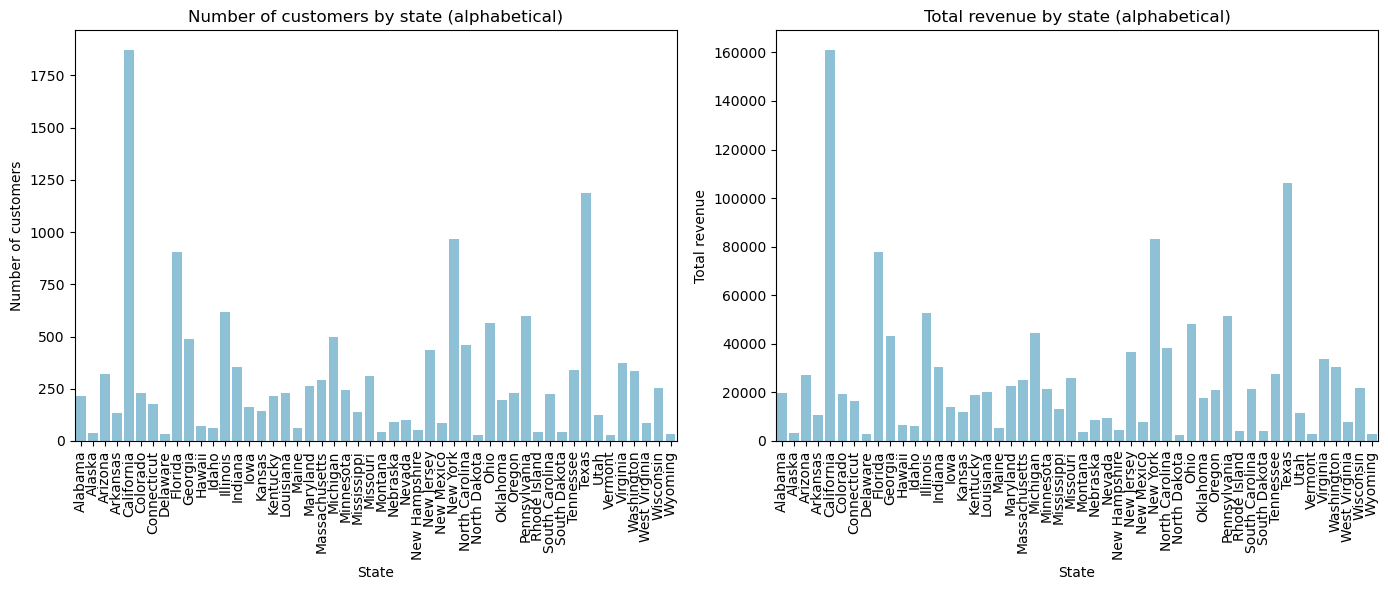

In [73]:
# count of customers by state
statewise_customer_count = data.groupby('state')['customer_id'].nunique().reset_index()
statewise_customer_count.rename(columns={'customer_id': 'number_of_customers'}, inplace=True)

# revenue by state
statewise_revenue = data.groupby('state')['revenue'].sum().reset_index()

# create figure
plt.figure(figsize=(14, 6))

# count of customers by state
plt.subplot(1, 2, 1)
sns.barplot(x='state', y='number_of_customers', data=statewise_customer_count, color='#82C6E2')
plt.xticks(rotation=90)
plt.title('Number of customers by state (alphabetical)')
plt.xlabel('State')
plt.ylabel('Number of customers')

# revenue by state
plt.subplot(1, 2, 2)
sns.barplot(x='state', y='revenue', data=statewise_revenue, color='#82C6E2')
plt.xticks(rotation=90)
plt.title('Total revenue by state (alphabetical)')
plt.xlabel('State')
plt.ylabel('Total revenue')

# show plots
plt.tight_layout()
plt.show()

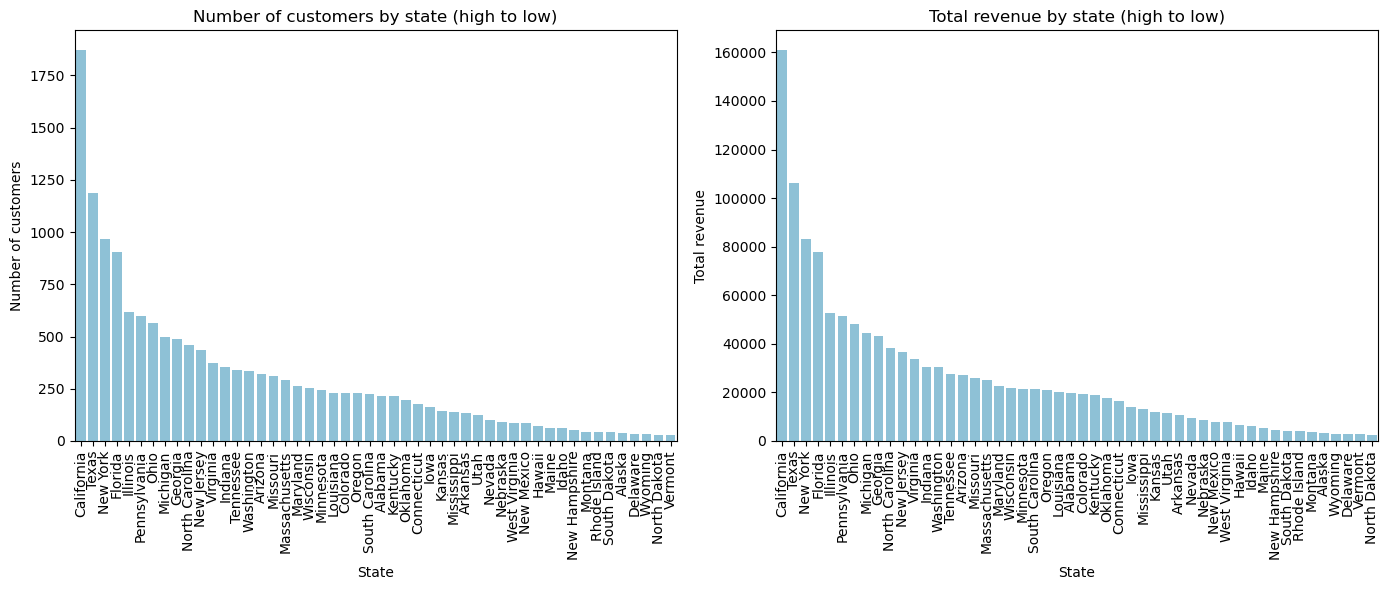

In [74]:
# sort state from high to low values for numbers of customers and total revenue
statewise_customer_count_sorted = statewise_customer_count.sort_values(by='number_of_customers', ascending=False)
statewise_revenue_sorted = statewise_revenue.sort_values(by='revenue', ascending=False)

# create figure
plt.figure(figsize=(14, 6))

# count of customers by state
plt.subplot(1, 2, 1)
sns.barplot(x='state', y='number_of_customers', data=statewise_customer_count_sorted, color='#82C6E2')
plt.xticks(rotation=90)
plt.title('Number of customers by state (high to low)')
plt.xlabel('State')
plt.ylabel('Number of customers')

# revenue by state
plt.subplot(1, 2, 2)
sns.barplot(x='state', y='revenue', data=statewise_revenue_sorted, color='#82C6E2')
plt.xticks(rotation=90)
plt.title('Total revenue by state (high to low)')
plt.xlabel('State')
plt.ylabel('Total revenue')

# show plots
plt.tight_layout()
plt.show()

In [75]:
# calculate cumulative sum of customers
statewise_customer_count_sorted['cumulative_customers'] = statewise_customer_count_sorted['number_of_customers'].cumsum()

# calculate cumulative % of total customers
total_customers = statewise_customer_count_sorted['number_of_customers'].sum()
statewise_customer_count_sorted['cumulative_percentage'] = (statewise_customer_count_sorted['cumulative_customers'] / total_customers) * 100

# top 10 states by number of customers with cumulative %
statewise_customer_count_sorted.head(10)

,state,number_of_customers,cumulative_customers,cumulative_percentage
4,California,1872,1872,12.480000
42,Texas,1187,3059,20.393333
31,New York,965,4024,26.826667
8,Florida,904,4928,32.853333
12,Illinois,617,5545,36.966667
37,Pennsylvania,598,6143,40.953333
34,Ohio,566,6709,44.726667
21,Michigan,498,7207,48.046667
9,Georgia,489,7696,51.306667
32,North Carolina,459,8155,54.366667


In [76]:
# calculate cumulative sum of customers
statewise_revenue_sorted['cumulative_revenue'] = statewise_revenue_sorted['revenue'].cumsum()

# calculate cumulative % of total customers
total_revenue = statewise_revenue_sorted['revenue'].sum()
statewise_revenue_sorted['cumulative_percentage'] = (statewise_revenue_sorted['cumulative_revenue'] / total_revenue) * 100

# top 10 states by revenue with cumulative %
statewise_revenue_sorted.head(10)

,state,revenue,cumulative_revenue,cumulative_percentage
4,California,161040.89,161040.89,12.310696
42,Texas,106294.45,267335.34,20.436325
31,New York,83242.74,350578.08,26.799778
8,Florida,77651.75,428229.83,32.735830
12,Illinois,52649.35,480879.18,36.760585
37,Pennsylvania,51595.35,532474.53,40.704767
34,Ohio,48010.94,580485.47,44.374941
21,Michigan,44424.81,624910.28,47.770975
9,Georgia,43426.41,668336.69,51.090687
32,North Carolina,38418.15,706754.84,54.027544


**Considerations for number of customers by state and top 10 states for n. customers:**

- California has the highest number of customers (1872) with a substantial lead over the seconda state, Texas, with 1187
- The cumulative customer count and percentage show that 26.82% of the customer base is from California, Texas or New York, and that 51.31% of the customers are based in 9 states out of 50 in the US
- While the company might focus on the top-performing states to leverage the existing customer base for growth, untapped potential in states with fewer customers is a strong opportunity to increase market share
- With the information provided, we don't know why some states have fewer customers: it could be due for example to less effective marketing, stronger competition, or perhaps a lower demand for company products

**Considerations for total revenue by state and top 10 states for revenue:**

- California leads by a significant margin in total revenue, followed by Texas and New York (suggests a heavy concentration of revenue in a few key states similar the the number of customers by state)
- The cumulative revenue and percentages illustrate that 26.8% of the revenue is from California, Texas and New York, and that 51.09% of the revenue comes from 9 states out of 50 in the US
- Once again, states contributing lower revenue could represent untapped markets or areas where the company has less market penetration
- The data can inform where to focus marketing and sales efforts, perhaps investing more resources into high-revenue states to capitalize on existing strongholds or developing strategies to increase the customer spend in states with many customers but lower revenue

## 8. Statistical experimentation

### 8.1 Sales methods and revenue

 - We compare the impact of sales_method (categorical) on revenue (continuous) with the analysis of variance (ANOVA) to determine if there are statistically significant differences in revenue among the different sales methods
 - If ANOVA shows a significant difference, you can perform post-hoc tests (e.g., Tukey's HSD) to identify which sales methods are significantly different from each other in terms of revenue
 - H0: There is no significant difference in the mean revenue among the different sales methods
 - H1: There is a significant difference in the mean revenue among at least one pair of sales methods

In [77]:
# drop rows with missing revenue entries
data_filtered = data.dropna(subset=['revenue'])

# perform ANOVA test
anova_result = stats.f_oneway(
    data_filtered[data_filtered['sales_method'] == 'Email']['revenue'],
    data_filtered[data_filtered['sales_method'] == 'Call']['revenue'],
    data_filtered[data_filtered['sales_method'] == 'Email and call']['revenue']
)

# print ANOVA result
print("ANOVA Result:")
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

# perform Tukey HSD test for post hoc analysis
tukey_result = pairwise_tukeyhsd(data_filtered['revenue'], data_filtered['sales_method'])

# print Tukey HSD results
print("\nTukey HSD Results:")
print(tukey_result)

ANOVA Result:
F-statistic: 63317.55841824496
p-value: 0.0

Tukey HSD Results:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1     group2     meandiff p-adj  lower    upper   reject
-------------------------------------------------------------
  Call          Email  49.5302   0.0  48.8721  50.1883   True
  Call Email and call 136.0538   0.0 135.1554 136.9522   True
 Email Email and call  86.5235   0.0  85.6704  87.3767   True
-------------------------------------------------------------


- Based on the ANOVA test results, there is strong evidence to reject the null hypothesis (H0) and conclude that there is a significant difference in mean revenue among the different sales methods, as indicated by the low p-value (p < 0.05)
- Based on the Tukey HSD test results, all pairs of sales methods ('Call' vs. 'Email', 'Call' vs. 'Email and call', 'Email' vs. 'Email and call') have significantly different mean revenues
- In summary, the statistical tests confirm that there are significant differences in mean revenue among the different sales methods, and all pairs of sales methods show significant differences in revenue

### 8.2 Sales methods and number of units sold

- H0: There is no statistically significant difference in the mean number of units sold among the different sales methods
- H1: There is a statistically significant difference in the mean number of units sold among at least one pair of sales methods

In [78]:
# perform ANOVA test
anova_result = stats.f_oneway(
    data_filtered[data_filtered['sales_method'] == 'Email']['nb_sold'],
    data_filtered[data_filtered['sales_method'] == 'Call']['nb_sold'],
    data_filtered[data_filtered['sales_method'] == 'Email and call']['nb_sold']
)

# print ANOVA result
print("ANOVA Result:")
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

# perform Tukey HSD test for post hoc analysis
tukey_result = pairwise_tukeyhsd(data_filtered['nb_sold'], data_filtered['sales_method'])

# print Tukey HSD results
print("\nTukey HSD Results:")
print(tukey_result)

ANOVA Result:
F-statistic: 2659.407924815711
p-value: 0.0

Tukey HSD Results:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1     group2     meandiff p-adj lower  upper  reject
---------------------------------------------------------
  Call          Email   0.2221   0.0  0.155 0.2892   True
  Call Email and call   2.6857   0.0 2.5941 2.7774   True
 Email Email and call   2.4636   0.0 2.3766 2.5506   True
---------------------------------------------------------


- Same outcome of 8.1, we reject H0 and accept H1, meaning that there are significant differences in mean number of products sold among the different sales methods, and all pairs of sales methods show significant differences in the number of products sold

### 8.3 Sales methods and number of site visits

- H0: There is no statistically significant difference in the mean number of site visits among the different sales methods
- H1: There is a statistically significant difference in the mean number of site visits among at least one pair of sales methods

In [79]:
# perform ANOVA test
anova_result = stats.f_oneway(
    data_filtered[data_filtered['sales_method'] == 'Email']['nb_site_visits'],
    data_filtered[data_filtered['sales_method'] == 'Call']['nb_site_visits'],
    data_filtered[data_filtered['sales_method'] == 'Email and call']['nb_site_visits']
)

# print ANOVA result
print("ANOVA Result:")
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

# perform Tukey HSD test for post hoc analysis
tukey_result = pairwise_tukeyhsd(data_filtered['nb_site_visits'], data_filtered['sales_method'])

# print Tukey HSD results
print("\nTukey HSD Results:")
print(tukey_result)

ANOVA Result:
F-statistic: 379.0648663081893
p-value: 5.011332990203822e-161

Tukey HSD Results:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1     group2     meandiff p-adj lower  upper  reject
---------------------------------------------------------
  Call          Email   0.3117   0.0 0.1619 0.4616   True
  Call Email and call   2.3163   0.0 2.1117  2.521   True
 Email Email and call   2.0046   0.0 1.8103 2.1989   True
---------------------------------------------------------


- Same outcome of 8.1 and 8.2, we reject H0 and accept H1, meaning that there are significant differences in mean number of site visits among the different sales methods, and all pairs of sales methods show significant differences in the number of site visits

### 8.4 Sales methods and years as customer

- H0: There is no statistically significant difference in the mean number of years as customer among the different sales methods
- H1: There is a statistically significant difference in the mean number of years as customer among at least one pair of sales methods

In [80]:
# perform ANOVA test
anova_result = stats.f_oneway(
    data_filtered[data_filtered['sales_method'] == 'Email']['years_as_customer'],
    data_filtered[data_filtered['sales_method'] == 'Call']['years_as_customer'],
    data_filtered[data_filtered['sales_method'] == 'Email and call']['years_as_customer']
)

# print ANOVA result
print("ANOVA Result:")
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

# perform Tukey HSD test for post hoc analysis
tukey_result = pairwise_tukeyhsd(data_filtered['years_as_customer'], data_filtered['sales_method'])

# print Tukey HSD results
print("\nTukey HSD Results:")
print(tukey_result)

ANOVA Result:
F-statistic: 12.153961109762827
p-value: 5.323584259939617e-06

Tukey HSD Results:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1     group2     meandiff p-adj   lower   upper  reject
------------------------------------------------------------
  Call          Email   -0.165  0.188 -0.3864  0.0564  False
  Call Email and call  -0.6335    0.0 -0.9358 -0.3312   True
 Email Email and call  -0.4685 0.0004 -0.7555 -0.1814   True
------------------------------------------------------------


- The ANOVA result indicates that there is a statistical evidence to reject H0, meaning that there is a significant difference in the mean number of years as a customer among at least one pair of sales methods
- The Tukey HSD results show that the comparison between 'Call' and 'Email' does not show a statistically significant difference (p-value > 0.05)
- The Tukey HSD results show that the comparison between 'Call' and 'Email and call', as well as 'Email' and 'Email and call', both show statistically significant differences (p-value < 0.05)

## <span style="color: red;">9. Q5 bonus answer (based on 7 and 8)</span>

**Q5: We don’t really know if there are other differences between the customers in each group, so anything you can tell us would be really helpful to give some context to what went well.**

The analysis reveals several key insights into customer segmentation, geographical distribution, and the impact of different sales methods on various aspects of the business:

**Customer segmentation:**

- By purchase volume: we segmented customers into 'High Volume' and 'Standard' buyers based on the total number of products purchased. Approximately 34.33% of customers buy at least 10 items (median), while 65.67% buy fewer products
- By site engagement level: customers were categorized as 'High' or 'Low' based on their website visit frequency. About 55.56% of customers visit the website more than the average (24.99 times), while 44.44% visit less frequently

**Geographical distribution:**

- Number of customers by state: California stands out with the highest number of customers (1872), followed by Texas with 1187. The top three states, including New York, make up 26.82% of the customer base, while 51.31% of customers are concentrated in just 9 out of 50 states
- Total revenue by state: California leads in total revenue, indicating a concentration of revenue in a few key states. Similar to customer count, 26.8% of revenue comes from California, Texas, and New York. This suggests potential untapped markets in states with fewer customers and revenue

**Impact of sales methods on revenue:**

- Statistical experimentation: an ANOVA test demonstrates a significant difference in mean revenue among different sales methods, and Tukey HSD tests confirm that all pairs of sales methods have significantly different mean revenues. In summary, there are significant differences in revenue among the sales methods
- The company's approach to sales has a tangible effect on the overall revenue generated

**Impact of sales methods on number of units sold and site visits:**

- Similar to the revenue analysis, both the number of units sold and site visits also show significant differences among the sales methods, as confirmed by ANOVA and Tukey HSD tests
- The choice of how the company interacts with customers affects their buying behavior
- The way sales are conducted can influence customers' interest in exploring the company's offerings online

**Impact of sales methods on years as a customer:**

- The ANOVA test suggests a significant difference in the mean number of years as a customer among at least one pair of sales methods. However, the Tukey HSD results reveal that the 'Call' vs. 'Email' comparison does not show a statistically significant difference, while 'Call' vs. 'Email and call' and 'Email' vs. 'Email and call' do